<img src="https://blogs.iadb.org/energia/wp-content/uploads/sites/16/2020/04/Oil-price-market-2.jpg" style="width:100%;">

#AI-Driven Demand Forecasting for Oil and Gas Products
We have a comprehensive dataset of worldwide crude oil prices starting from 1983, which includes both the price changes and their corresponding percentage changes over time. This historical data provides a valuable foundation for developing a forecasting solution aimed at predicting oil prices for the upcoming 18 months, enabling better demand planning and market analysis.

#1. SETUP AND REPRODUCIBILITY

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


#2. DATA LOADING AND EXPLORATION

<Axes: xlabel='date'>

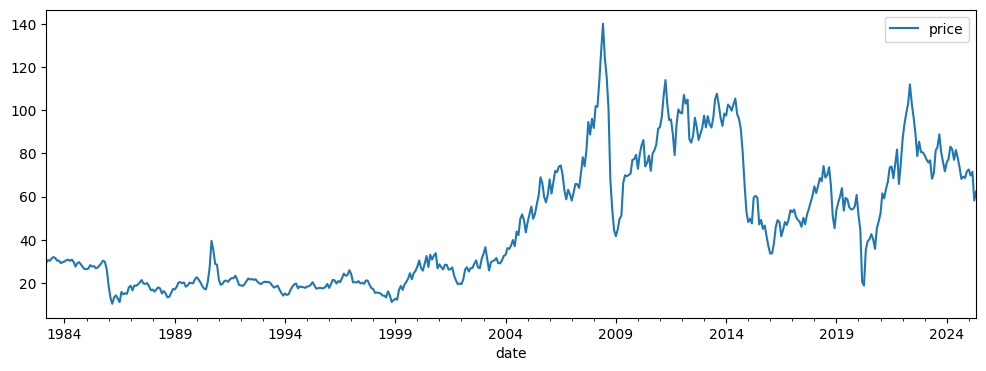

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('/content/crude-oil-price.csv',index_col='date', parse_dates=True, usecols=['date', 'price'])
df.index.freq = 'MS'

df.plot(figsize=(12, 4))

#3. CHECK THE MISSING VALUES

In [ ]:
print(df.isnull().sum())

# start_date = '1985-01-01'
# end_date = '2000-01-01'
# df = df[(df.index >= start_date) & (df.index <= end_date)]
# df.plot(figsize=(12, 4))

#4. TIME SERIES DECOMPOSITION

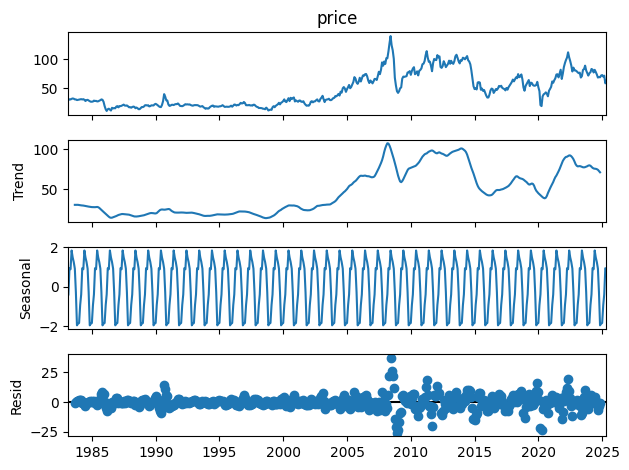

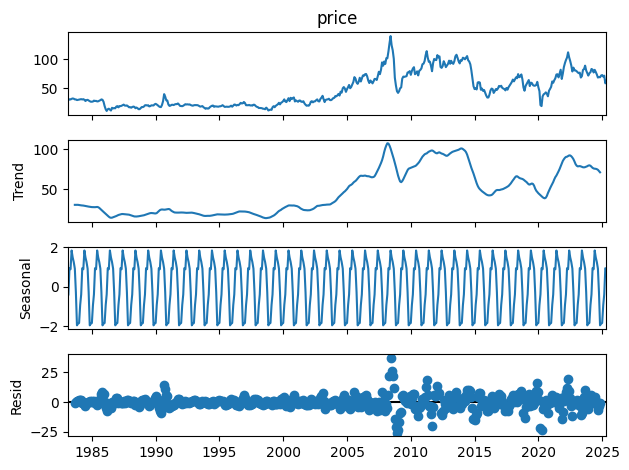

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['price'])
decompose.plot()

#5. TRAIN-TEST SPLIT

In [ ]:
total_size = len(df)
# test_size = int(len(df)*0.15)
test_size = 12

train_set = df[:total_size-test_size]
test_set = df[total_size-test_size:]

#5. DATA SCALING

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_set)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

#6. SEQUENCE GENERATION FOR LSTM

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 18 # 18
n_features = 1
generator = TimeseriesGenerator(scaled_train_set, scaled_train_set,
                                length=n_input, batch_size=1) # 1

#7. LSTM MODEL CONSTRUCTION

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_input, n_features))) # 32
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

# 8. MODEL TRAINING

In [ ]:
model.fit(generator, epochs=5) # 10

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0159
Epoch 2/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050
Epoch 3/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 4/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0032
Epoch 5/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034


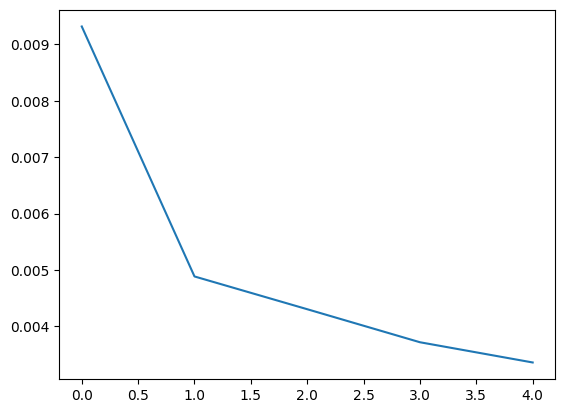

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
last_train_batch = scaled_train_set[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


array([[0.5009131]], dtype=float32)

#9. FORECASTING AND PREDICTIONS

In [ ]:
test_predictions = []
first_eval_batch = scaled_train_set[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_set)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test_set['Predictions'] = true_predictions

<ipython-input-18-22ce99fad483>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Predictions'] = true_predictions


<Axes: xlabel='date'>

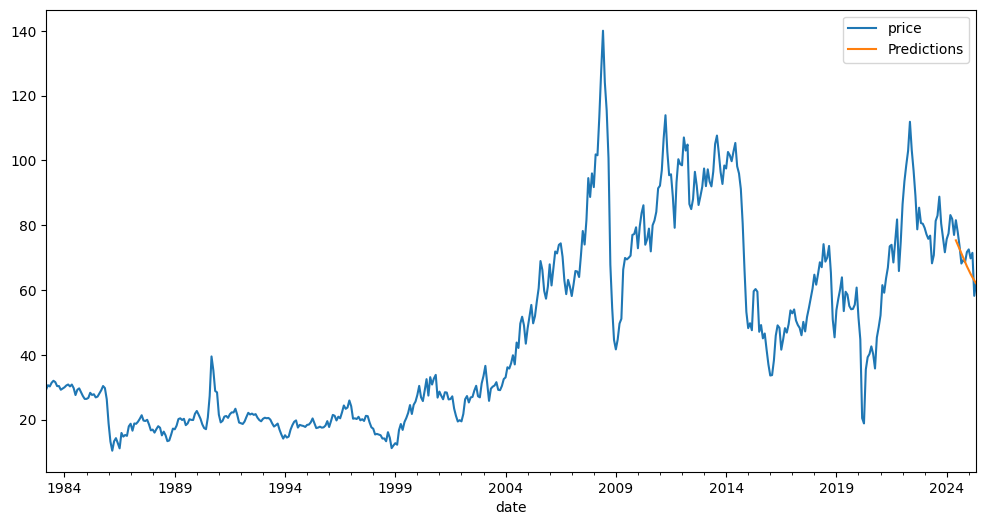

In [ ]:
full_set = pd.concat([train_set, test_set])
full_set.plot(figsize=(12, 6))

#10. MODEL EVALUATION

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test_set['price'], test_set['Predictions']))
print(rmse)
print("#"*32)
print(test_set)

4.358564419943234
################################
                             price  Predictions
date                                           
2024-06-01 00:00:00+00:00  81.5400    75.328317
2024-07-01 00:00:00+00:00  77.9100    73.985567
2024-08-01 00:00:00+00:00  73.5500    72.617140
2024-09-01 00:00:00+00:00  68.1700    71.242398
2024-10-01 00:00:00+00:00  69.2600    69.888395
2024-11-01 00:00:00+00:00  68.6300    68.579196
2024-12-01 00:00:00+00:00  71.7200    67.310769
2025-01-01 00:00:00+00:00  72.5300    66.104672
2025-02-01 00:00:00+00:00  69.7600    64.978830
2025-03-01 00:00:00+00:00  71.4800    63.928911
2025-04-01 00:00:00+00:00  58.2100    62.966049
2025-05-01 00:00:00+00:00  62.2914    62.075000


#11. MODEL SAVING

In [ ]:
model.save('model.keras')